# Лабораторная работа № 2

## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 1

В данной части работы рассмотрены:
- подготовка признаков для решения задачи **линейной регрессии**;
- создание и обучение модели линейной регрессии;
- оценка качества модели.ели.

### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [30]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, length, when, year, month, dayofweek, udf
from pyspark.sql.types import DoubleType, IntegerType, FloatType
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.

In [31]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("Lab 2 Linear Regression")
    conf.setMaster("local[*]")
    # conf.set("spark.submit.deployMode", "client")
    # КРИТИЧЕСКИЕ настройки памяти
    conf.set("spark.driver.memory", "8g")          
    conf.set("spark.executor.memory", "6g")        
    conf.set("spark.memory.fraction", "0.8")        
    conf.set("spark.memory.storageFraction", "0.3") 
    
    # Настройки для больших данных
    conf.set("spark.sql.adaptive.enabled", "true")
    conf.set("spark.sql.adaptive.coalescePartitions.enabled", "true")
    conf.set("spark.sql.adaptive.skew.enabled", "true")
    conf.set("spark.sql.shuffle.partitions", "100")  
    
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///b")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [32]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`.

In [33]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Загрузка датасета

In [34]:
df = spark.read.parquet("hdfs://hadoop-namenode:9820/data/mattiev_database/movies_lab1_cleaned")

def print_df(df):
    return df.limit(10).toPandas()

In [35]:
print_df(df)

,asin,reviewerID,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime
0,B005HS4CUY,A00116683339FAW9XGHO,Mindy Graves,misleading would not play on our DVD player ...,1.0,misleading would not play on our DVD player re...,1490140800,2017-03-22
1,B001J710YS,A0018632VUVKRGSYBEAT,cierra,This product was amazing! It came in record ti...,5.0,Loved This,1353801600,2012-11-25
2,6301753534,A00222906VX8GH7X6J6B,Miguel A. Martinez,good price,5.0,Five Stars,1427846400,2015-01-04
3,B01COCKFOM,A0022400EY2L9WUZ2QRQ,Amazon Customer,I loved it great movie,5.0,Gotta see it,1474588800,2016-09-23
4,B00AEJM61I,A00849873KP522T77IL8,karen stephens,great movie to watch with all the lights of on...,5.0,Five Stars,1443139200,2015-09-25
5,B00EXDW1WA,A01008638Q2KKEWA1SAJ,Karen T.,Hilarious!!!!,5.0,Five Stars,1468540800,2016-07-15
6,0788812467,A0145698H8AAYMRXLBD8,cdy7626,We had this on VHS. Now needed it on DVD. Su...,5.0,Sure its been out a long time (new technology ...,1418515200,2014-12-14
7,B0000E32X3,A0149220O8WD7KG3O5XR,Mike McGrew,All Seasons of Frasier worth watching,5.0,Good solid entertainment,1463788800,2016-05-21
8,B0001NBNJ8,A0149220O8WD7KG3O5XR,Mike McGrew,I think Frasier like fine wine just got better...,5.0,Just gets better,1464566400,2016-05-30
9,B001GCUO5M,A0156038BA2FABM6OVXN,Rob Stidham,One of my all-time favorite movie's. Looks gre...,5.0,RUN,1456185600,2016-02-23


Расшифровка столбцов
| Название столбца  | Расшифровка |
| ------------- | ------------- |
| asin | ID товара  |
|reviewerID  |ID рецензента  |
|reviewerName  |Имя рецензента  |
|reviewText  |Текст отзыва  |
|overall  |Общая оценка  (1.0-5.0)|
|summary  |Краткое описание  |
|unixReviewTime  |Время отзыва в Unix-времени  
| reviewTime | Время отзыва ||

Вспомним схему данных

In [36]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- overall: float (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: integer (nullable = true)
 |-- reviewTime: string (nullable = true)



Вычислим количество строк в датафрейме.

In [37]:
df.count()

6439543

### Постановка задачи Линейной Регрессии
Для датасета, заданного представленными колонками, требуется построить модель линейной регрессии 
для оценки рейтинга отзыва `(overall)` по всем остальным признакам.

Для оценки качества обучения следует использовать метрики RMSE и R².

### Подготовка и кодирование признаков

Для корректной работы трансформеров преобразуем столбец unixReviewTime к типу DoubleType

In [38]:
df = df.withColumn("unixReviewTime", col("unixReviewTime").cast(DoubleType()))

Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный csv-файл. Он понадобится в следующей лабораторной работе.

In [39]:
# Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный csv-файл
def save_sample_to_csv(data: DataFrame, file_path: str, 
                       sample_size: int = 6439543) -> DataFrame:
    """
    Сохраняет первые `sample_size` строк из DataFrame в CSV-файл 
    на драйвере и возвращает DataFrame с оставшимися данными.

    Args:
        data (DataFrame): DataFrame, из которого нужно извлечь
            строки.
        file_path (str): Путь для сохранения CSV-файла.
        sample_size (int): Количество строк для сохранения
            (по умолчанию 1000).

    Returns:
        DataFrame: DataFrame с оставшимися данными.
    """
    # Определяем пропорции для разделения
    sample_fraction = sample_size / data.count()
    remaining_fraction = 1 - sample_fraction

    # Разделяем DataFrame на два непересекающихся набора данных
    sample_data, remaining_data = data.randomSplit(
        [sample_fraction, remaining_fraction]
    )

    # Сохраняем извлеченные строки в CSV-файл на драйвере
    try:
        with open(file_path, mode="w", newline="") as file:
            writer = csv.writer(file)

            # Записываем заголовок
            writer.writerow(data.columns)

            # Записываем строки
            for row in sample_data.take(sample_size):
                writer.writerow(row)
        print(f"Файл \"{file_path}\" с данными успешно создан.")

    except Exception as e:
        print(f"Ошибка при записи файла: {e}")

    return remaining_data

Определяем путь для сохранения csv-файла.

In [40]:
path = "Movies_and_TV_cleaned.csv"

df = save_sample_to_csv(data=df, file_path=path, sample_size=1000)

Файл "Movies_and_TV_cleaned.csv" с данными успешно создан.


Оцениваем, сколько строк в датасете осталось

In [41]:
df.count()

6438572

Разделим датасет на обучающую и тестовую выборки.

In [42]:
train_df, test_df = df.randomSplit([0.8, 0.2])

In [43]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test dataset size: {test_df.count()}")

Train dataset size: 5151595
Test dataset size: 1286977


Идентификаторы asin, reviewerID, reviewerName не оказывают влияния на оценку отзыва. Использовать их в модели нет смысла.

Остальные признаки сгруппируем по их типу:

* **Категориальные признаки**: пока отсутствуют в исходных данных
* **Бинарные признаки**: создадим из текстовых данных
* **Количественные признаки**: временные метки и производные от текста
* **Текстовые признаки**: преобразуем в числовые (длина текста)

In [47]:
# Создадим дополнительные признаки 

# Сложность текста (количество слов)
df = df.withColumn("reviewWordCount", 
                   udf(lambda x: len(x.split()) if x and isinstance(x, str) else 0, 
                       IntegerType())("reviewText"))

# Наличие эмоциональных слов
positive_words = ["good", "great", "excellent", "amazing", "love", "awesome", "perfect", 
                  "wonderful", "fantastic", "best", "nice", "beautiful", "outstanding"]
df = df.withColumn("positiveCount", 
                   udf(lambda x: sum(1 for word in positive_words if word in x.lower()) 
                       if x and isinstance(x, str) else 0, 
                       IntegerType())("reviewText"))

# Наличие негативных слов
negative_words = ["bad", "terrible", "awful", "hate", "disappointing", "poor", 
                  "worst", "boring", "horrible", "disappointed", "waste", "rubbish"]
df = df.withColumn("negativeCount", 
                   udf(lambda x: sum(1 for word in negative_words if word in x.lower()) 
                       if x and isinstance(x, str) else 0, 
                       IntegerType())("reviewText"))

# Соотношение положительных и отрицательных слов (с обработкой деления на 0)
df = df.withColumn("sentimentRatio", 
                   when(col("negativeCount") == 0, 
                        when(col("positiveCount") > 0, 10).otherwise(1))
                   .otherwise(col("positiveCount") / col("negativeCount")))

#  Наличие знаков препинания (индикатор эмоциональности)
df = df.withColumn("exclamationCount",
                   udf(lambda x: x.count('!') if x and isinstance(x, str) else 0,
                       IntegerType())("reviewText"))


# Добавим временные признаки в основной df
df = df.withColumn("reviewYear", year("reviewTime"))
df = df.withColumn("reviewMonth", month("reviewTime")) 
df = df.withColumn("reviewDayOfWeek", dayofweek("reviewTime"))

# Добавим длину текста отзыва и summary
df = df.withColumn("reviewTextLength", length("reviewText"))
df = df.withColumn("summaryLength", length("summary"))

# Создадим бинарные признаки
df = df.withColumn("isLongReview", when(col("reviewTextLength") > 100, 1).otherwise(0))
df = df.withColumn("isDetailedSummary", when(col("summaryLength") > 10, 1).otherwise(0))

# Обновим train и test
def add_features(df):
    return (df
            .withColumn("reviewTextLength", length("reviewText"))
            .withColumn("summaryLength", length("summary"))
            .withColumn("isLongReview", when(col("reviewTextLength") > 100, 1).otherwise(0))
            .withColumn("isDetailedSummary", when(col("summaryLength") > 10, 1).otherwise(0))
            .withColumn("reviewYear", year("reviewTime"))
            .withColumn("reviewMonth", month("reviewTime"))
            .withColumn("reviewDayOfWeek", dayofweek("reviewTime"))
            .withColumn("reviewWordCount", 
                       udf(lambda x: len(x.split()) if x and isinstance(x, str) else 0, 
                           IntegerType())("reviewText"))
            .withColumn("positiveCount", 
                       udf(lambda x: sum(1 for word in positive_words if word in x.lower()) 
                           if x and isinstance(x, str) else 0, 
                           IntegerType())("reviewText"))
            .withColumn("negativeCount", 
                       udf(lambda x: sum(1 for word in negative_words if word in x.lower()) 
                           if x and isinstance(x, str) else 0, 
                           IntegerType())("reviewText"))
            .withColumn("sentimentRatio", 
                       when(col("negativeCount") == 0, 
                            when(col("positiveCount") > 0, 10).otherwise(1))
                       .otherwise(col("positiveCount") / col("negativeCount")))
            .withColumn("exclamationCount",
                       udf(lambda x: x.count('!') if x and isinstance(x, str) else 0,
                           IntegerType())("reviewText")))

# Примените к train_df и test_df
train_df = add_features(train_df)
test_df = add_features(test_df)

In [48]:
# Определим группы признаков
categorical_features = []  # Категориальные признаки
binary_features = ["isLongReview", "isDetailedSummary"]
numeric_features = ["unixReviewTime", "reviewTextLength", "summaryLength", 
                   "reviewYear", "reviewMonth", "reviewDayOfWeek",
                   "reviewWordCount", "positiveCount", "negativeCount", 
                   "sentimentRatio", "exclamationCount"]

# Целевая переменная
label_col = "overall"

print("Категориальные признаки:", categorical_features)
print("Бинарные признаки:", binary_features)
print("Числовые признаки:", numeric_features)
print("Целевая переменная:", label_col)

Категориальные признаки: []
Бинарные признаки: ['isLongReview', 'isDetailedSummary']
Числовые признаки: ['unixReviewTime', 'reviewTextLength', 'summaryLength', 'reviewYear', 'reviewMonth', 'reviewDayOfWeek', 'reviewWordCount', 'positiveCount', 'negativeCount', 'sentimentRatio', 'exclamationCount']
Целевая переменная: overall


Выведем итоговый датасет перед обучением модели

In [49]:
print_df(df)

,asin,reviewerID,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime,reviewWordCount,positiveCount,negativeCount,sentimentRatio,summaryLength,exclamationCount,reviewYear,reviewMonth,reviewDayOfWeek,reviewTextLength,isLongReview,isDetailedSummary
0,0001526863,A2OI3BVXGLBFXP,Judy K. Pilewski,"My grandchildren love this DVD, even as dated ...",5.0,My grandchildren love this DVD,1.465776e+09,2016-06-13,23,1,0,10.0,30,0,2016,6,2,122,1,1
1,0001527665,A38LY2SSHVHRYB,Jodie Vesely,This is a great movie for a missionary going i...,4.0,Good Movie! Great for cross-cultural missionar...,1.356480e+09,2012-12-26,31,1,0,10.0,50,0,2012,12,4,161,1,1
2,0005000009,A33R5SFMQ2PDH4,Connie,Excellent video and I thorougly enjoyed it ve...,5.0,Where Jesus Walked,1.397434e+09,2014-04-14,26,1,0,10.0,18,0,2014,4,2,152,1,1
3,0005000009,A3OL9JYLV8TIWN,bullett,not what I was looking for.,1.0,One Star,1.429661e+09,2015-04-22,6,0,0,1.0,8,0,2015,4,4,27,0,0
4,0005000009,ABRIR6R7IYMYX,carmen,Very nice movie,5.0,Five Stars,1.457568e+09,2016-10-03,3,1,0,10.0,10,0,2016,10,2,15,0,0
5,0005019281,A18G2L78C27HOC,T. Clark,"Great classic, the Fonz rules",5.0,Five Stars,1.482538e+09,2016-12-24,5,1,0,10.0,10,0,2016,12,7,29,0,0
6,0005019281,A18LQQ6KUK9IF6,Klaus2017,Not the best acting. The story is a classic so...,3.0,Great story not the best acting.,1.387325e+09,2013-12-18,34,1,1,1.0,32,0,2013,12,4,171,1,1
7,0005019281,A1BOKOBCBRVSKD,Laura D,Have been looking for the Henry Winkler 'An Am...,5.0,Finally I Found It!,1.389053e+09,2014-07-01,22,0,0,1.0,19,1,2014,7,3,128,1,1
8,0005019281,A1QZKM8M6866I8,Amazon Customer,While Winkler's make up job is dated and not r...,5.0,A nice version of Christmas carol - winkler do...,1.481242e+09,2016-09-12,35,1,0,10.0,59,0,2016,9,2,162,1,1
9,0005019281,A1SA7NXJV1YOJZ,Thomas A. Kelly,"""I had a copy of the original DVD but ufortuna...",5.0,A GREAT VERSION OF A CLASSIC.,1.389226e+09,2014-09-01,48,1,0,10.0,29,0,2014,9,2,247,1,1


Создадим конвейер обработки данных, включающий модель линейной регресси

In [50]:
# Создадим конвейер обработки данных для LINEAR REGRESSION (как в примере)
def create_linear_regression_pipeline(categorical_features: list[str], numeric_features: list[str], 
                                    binary_features: list[str], label_col: str, max_iter: int) -> Pipeline:
    
    stages = []
    
    # # Обработка категориальных признаков
    # if categorical_features:
    #     indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    #     onehot_categorical_features = [f"{feature}_ohe" for feature in categorical_features]
        
    #     string_indexer = StringIndexer(inputCols=categorical_features,
    #                                   outputCols=indexed_categorical_features,
    #                                   handleInvalid="keep")
    #     onehot_encoder = OneHotEncoder(inputCols=indexed_categorical_features,
    #                                   outputCols=onehot_categorical_features,
    #                                   dropLast=True,
    #                                   handleInvalid="keep")
    #     stages.extend([string_indexer, onehot_encoder])
    
    # Собираем числовые признаки в вектор
    vector_num_assembler = VectorAssembler(inputCols=numeric_features,
                                          outputCol="numeric_vector")
    stages.append(vector_num_assembler)
    
    # Масштабируем числовые признаки (ВАЖНО для Linear Regression)
    numeric_scaler = MinMaxScaler(inputCol="numeric_vector",
                                 outputCol="numeric_vector_scaled")
    stages.append(numeric_scaler)
    
    # Собираем все фичи в финальный вектор
    feature_cols = ["numeric_vector_scaled"] + binary_features
    
    vector_all_assembler = VectorAssembler(inputCols=feature_cols,
                                          outputCol="features")
    stages.append(vector_all_assembler)
    
    # СОЗДАЕМ LINEAR REGRESSION (как в примере)
    linear_regression = LinearRegression(featuresCol="features",
                                        labelCol=label_col,
                                        predictionCol="prediction",
                                        standardization=False,  # Т.к. уже масштабировали
                                        maxIter=max_iter)
    
    stages.append(linear_regression)
    
    # Создаем конвейер
    pipeline = Pipeline(stages=stages)
    
    return pipeline

In [51]:
# Создаем конвейер для Linear Regression
pipeline = create_linear_regression_pipeline(categorical_features=categorical_features,
                                           numeric_features=numeric_features,
                                           binary_features=binary_features,
                                           label_col=label_col,
                                           max_iter=15)
print("Конвейер успешно создан!")

Конвейер успешно создан!


### Обучение модели

Выполним **подбор гиперпараметров** модели линейной регрессии с помощью кросс-валидации на сетке

Создаем сетку параметров для кросс-валидации, получив объект `LinearRegression` из конвейера

In [52]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].regParam, [0.01, 0.1, 1.0]) \
    .addGrid(pipeline.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

Создаем экземпляр `RegressionEvaluator` для оценки модели

In [53]:
cv_evaluator = RegressionEvaluator(labelCol=label_col,
                                   predictionCol="prediction", 
                                   metricName="rmse")

Создаем объект `CrossValidator`

In [54]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=3,          
                                 parallelism=6)  

Обучаем модель конвейера с использованием кросс-валидации.

In [55]:
print("Начинаем обучение Linear Regression с кросс-валидацией...")
cv_model = cross_validator.fit(train_df)
print("Обучение завершено!")

Начинаем обучение Linear Regression с кросс-валидацией...
Обучение завершено!


Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [56]:
# Выведем параметры лучшей модели, определенной в ходе кросс-валидации
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    best_params = {
        "regParam": best_model.stages[-1].getRegParam(),
        "elasticNetParam": best_model.stages[-1].getElasticNetParam(),
        "maxIter": best_model.stages[-1].getMaxIter()
    }
    return best_params



In [58]:
print("Параметры лучшей модели Linear Regression:")
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

Параметры лучшей модели Linear Regression:
regParam: 0.01
elasticNetParam: 1.0
maxIter: 15


### Анализ процесса обучения

In [59]:
# Визуализируем изменение ошибки модели в ходе обучения и рассчитаем метрики на обучающем датасете
def plot_training_summary(cv_model: CrossValidatorModel) -> None:
    """
    Отображает графики зависимости значения ошибки от номера итерации на
    обучающей выборке, а также значения метрик RMSE и R^2.

    Args:
        cv_model (CrossValidatorModel): Обученная модель с использованием кросс-валидации.
    """
    # Получаем лучшую модель
    best_model = cv_model.bestModel

    # Получаем информацию о процессе обучения
    training_summary = best_model.stages[-1].summary

    # Получаем значения ошибки для каждой итерации
    objective_history = training_summary.objectiveHistory
    print(objective_history)

    # Строим график зависимости значения ошибки от номера итерации
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(objective_history)), 
                 y=objective_history, 
                 marker='o')
    plt.xlabel('Итерация')
    plt.ylabel('Ошибка')
    plt.title("Зависимость значения функции ошибки от номера итерации")

    # Получаем значения метрик
    rmse = training_summary.rootMeanSquaredError
    r2 = training_summary.r2

    # Добавляем значения метрик на график
    plt.text(0.95, 0.95, f"RMSE: {rmse:.2f}\nR^2: {r2:.2f}",
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8), zorder=5)
    plt.grid()

    plt.show()

[0.5000000000000009, 0.4833747433496804, 0.4290267604881494, 0.4268908536888936, 0.42466424770027517, 0.42402135693864845, 0.4239259677603867, 0.42391695771474924, 0.4239161619470111, 0.4239153643364693, 0.4239151227281975, 0.42391501002352394, 0.4239149287425064, 0.423914911805609, 0.42391491013914034, 0.42391490450805924]


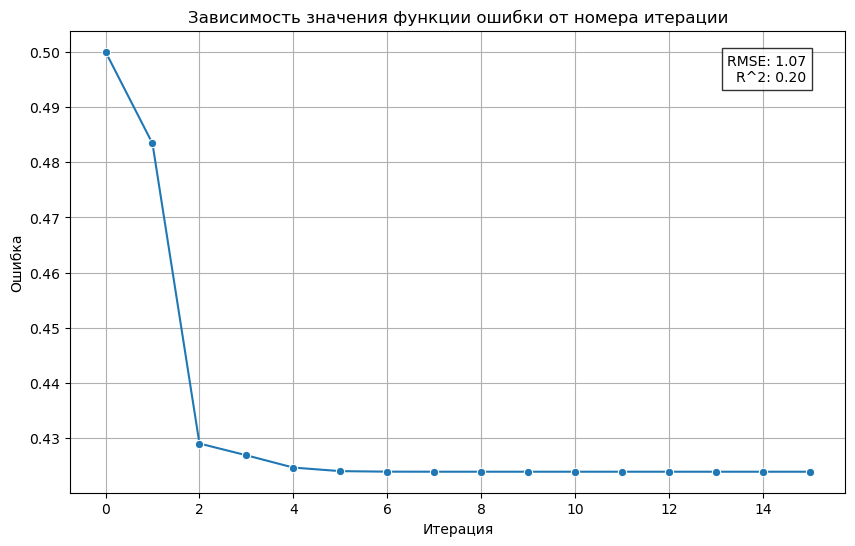

In [60]:
# Визуализируем процесс обучения
plot_training_summary(cv_model)

### Проверка обобщающей способности модели

Выполним предсказания на тестовой выборке.

Перегруппируем колонки датафрейма, переставив столбец с целевой переменной в конец,  чтобы его значения было удобно сравнивать с предсказанным


In [61]:
# Выполним предсказания на тестовой выборке
print("Выполняем предсказания на тестовой выборке...")
test_df_predictions = cv_model.transform(test_df)

# Перегруппируем колонки датафрейма, переставив столбец с целевой переменной в конец
right_columns_order = test_df_predictions.columns
right_columns_order.remove(label_col)
right_columns_order.append(label_col)

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)

print("Пример предсказаний (первые 10 строк):")
print_df(test_df_predictions)

Выполняем предсказания на тестовой выборке...
Пример предсказаний (первые 10 строк):


,asin,reviewerID,reviewerName,reviewText,summary,unixReviewTime,reviewTime,reviewTextLength,summaryLength,isLongReview,...,reviewWordCount,positiveCount,negativeCount,sentimentRatio,exclamationCount,numeric_vector,numeric_vector_scaled,features,prediction,overall
0,0001526863,A2OI3BVXGLBFXP,Judy K. Pilewski,"My grandchildren love this DVD, even as dated ...",My grandchildren love this DVD,1.465776e+09,2016-06-13,122,30,1,...,23,1,0,10.0,0,"[1465776000.0, 122.0, 30.0, 2016.0, 6.0, 2.0, ...","[0.8770802919708028, 0.003728858702889865, 0.0...","[0.8770802919708028, 0.003728858702889865, 0.0...",4.557873,5.0
1,0005000009,A33R5SFMQ2PDH4,Connie,Excellent video and I thorougly enjoyed it ve...,Where Jesus Walked,1.397434e+09,2014-04-14,152,18,1,...,26,1,0,10.0,0,"[1397433600.0, 152.0, 18.0, 2014.0, 4.0, 2.0, ...","[0.7616058394160584, 0.004727660141163936, 0.0...","[0.7616058394160584, 0.004727660141163936, 0.0...",4.557873,5.0
2,0005019281,A1SA7NXJV1YOJZ,Thomas A. Kelly,"""I had a copy of the original DVD but ufortuna...",A GREAT VERSION OF A CLASSIC.,1.389226e+09,2014-09-01,247,29,1,...,48,1,0,10.0,0,"[1389225600.0, 247.0, 29.0, 2014.0, 9.0, 2.0, ...","[0.7477372262773723, 0.007890531362365161, 0.0...","[0.7477372262773723, 0.007890531362365161, 0.0...",4.557873,5.0
3,0005019281,A25D9UYB75TNDW,Adam workman,I gave it a 4 just because i love the story of...,I gave it a 4 just because i love the story of...,1.479168e+09,2016-11-15,161,85,1,...,32,1,0,10.0,0,"[1479168000.0, 161.0, 85.0, 2016.0, 11.0, 3.0,...","[0.8997080291970803, 0.005027300572646157, 0.0...","[0.8997080291970803, 0.005027300572646157, 0.0...",4.557873,4.0
4,0005019281,A2K4AUMORPI9GZ,rwish34,Love anything to do with a Christmas carol. He...,aaaaaa! ...no fonz here!!,1.425514e+09,2015-05-03,180,25,1,...,29,3,0,10.0,1,"[1425513600.0, 180.0, 25.0, 2015.0, 5.0, 1.0, ...","[0.809051094890511, 0.005659874816886403, 0.02...","[0.809051094890511, 0.005659874816886403, 0.02...",4.557873,5.0
5,0005019281,A35GFOTJV50EFJ,Kat57961,Very well done.,Five Stars,1.481846e+09,2016-12-16,15,10,0,...,3,0,0,1.0,0,"[1481846400.0, 15.0, 10.0, 2016.0, 12.0, 6.0, ...","[0.9042335766423357, 0.00016646690637901184, 0...","[0.9042335766423357, 0.00016646690637901184, 0...",3.961996,5.0
6,0005019281,A3EWY61AK57EIW,briceynanny,This arrived in good time. It was in good cond...,American CC DVD,1.358813e+09,2013-01-22,130,15,1,...,27,1,0,10.0,0,"[1358812800.0, 130.0, 15.0, 2013.0, 1.0, 3.0, ...","[0.6963503649635037, 0.003995205753096284, 0.0...","[0.6963503649635037, 0.003995205753096284, 0.0...",4.557873,4.0
7,0005119367,A1D79P8RIESO8Y,ACJ,This film was expertly directed and brought ou...,Joseph,1.295914e+09,2011-01-25,136,6,1,...,24,1,0,10.0,0,"[1295913600.0, 136.0, 6.0, 2011.0, 1.0, 3.0, 2...","[0.5900729927007299, 0.004194966040751098, 0.0...","[0.5900729927007299, 0.004194966040751098, 0.0...",4.717920,5.0
8,0005119367,AFXYF1ADI5W98,Diane Clark,This is an AWESOME movie! Highly recommend. ...,Fantastic Family Movie!,1.414282e+09,2014-10-26,74,23,0,...,12,2,0,10.0,1,"[1414281600.0, 74.0, 23.0, 2014.0, 10.0, 1.0, ...","[0.79007299270073, 0.0021307764016513515, 0.01...","[0.79007299270073, 0.0021307764016513515, 0.01...",4.580828,5.0
9,0006486576,A2VMTIVVX1J2DU,Volfenstein,Saw this as a kid in Hindi and I've never forg...,Great movie...,1.370736e+09,2013-09-06,142,14,1,...,28,1,0,10.0,0,"[1370736000.0, 142.0, 14.0, 2013.0, 9.0, 6.0, ...","[0.7164963503649635, 0.0043947263284059125, 0....","[0.7164963503649635, 0.0043947263284059125, 0....",4.557873,5.0


Создадим функцию оценки модели: расчета метрик для некоторого датасета

In [62]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "rmse", "r2").

    Returns:
        float: Значение указанной метрики.
    """
    evaluator = RegressionEvaluator(labelCol=label_col, 
                                    predictionCol="prediction", 
                                    metricName=metric_name)
    metric_value = evaluator.evaluate(data)
    return metric_value

Оценим модель на тестовой выборке

In [63]:
print("Оценка модели на тестовой выборке:")
test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE на тестовых данных: {test_rmse:.4f}")
print(f"R² на тестовых данных: {test_r2:.4f}")

Оценка модели на тестовой выборке:
RMSE на тестовых данных: 1.0718
R² на тестовых данных: 0.2026


#### Выводы:
- Модель ошибается в среднем на 1 балл.
- Модель объясняет только 20% изменчивости оценок.
- Модель слабо предсказывает оценки отзывов.
- Большая часть изменчивости (80%) не объясняется текущими признаками.

### Сохранение модели

In [65]:
# Путь модели
model_path = f"linear_regression_movies_model"

database_name = "mattiev_database"

output_path = f"hdfs://hadoop-namenode:9820/data/{database_name}/{model_path}"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.save(output_path)
    print(f"Модель linear regression успешно сохранена в \"{output_path}\"")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Модель linear regression успешно сохранена в "hdfs://hadoop-namenode:9820/data/mattiev_database/linear_regression_movies_model"


Не забываем завершать `Spark`-сессию.

In [66]:
spark.stop()